# Links

https://chrsmrrs.github.io/datasets/docs/datasets/

In [34]:
## Standard libraries
import os
import json
import math
import numpy as np
import time
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression

## Imports for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

# Plotly
import plotly.graph_objects as go

# NetworkX
import networkx as nx

# Gensim
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import torch.utils.data as data
import torch.optim as optim

# Geometric
import torch_geometric
import torch_geometric.nn as geom_nn
from torch_geometric.nn import GCNConv, GraphConv, global_mean_pool
import torch_geometric.data as geom_data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader,ClusterData, ClusterLoader
from torch_geometric.utils import to_networkx

# PyTorch Lightning
import pytorch_lightning as pl

In [245]:
def visualize_graph(ax, G, color=None, labels=False, title=None, layout=lambda G : nx.spring_layout(G, seed=42)):
    ax.set_xticks([])
    ax.set_yticks([])
    node_color = 'white'
    if color is not None: node_color = color
    nx.draw_networkx(G, pos=layout(G), with_labels=labels,
                     node_color=node_color, cmap="Set2", node_size=100, ax=ax)
    if title: ax.set_title(title)

def visualize_embedding(ax, h, color, epoch=None, loss=None, title=None):
    ax.set_xticks([])
    ax.set_yticks([])
    h = h.detach().cpu().numpy()
    ax.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        ax.set_xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=10)
    if title: ax.set_title(title)
        
def visualize_model_embedding_spaces(models, modelnames):
    fig, ax = plt.subplots(1, len(models), figsize=(len(models)*4,4))
    x_min, x_max = -1, 1
    y_min, y_max = -1, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    for i, model in enumerate(models):
        assert model.classifier.in_features == 2
        name = modelnames[i]
        pred = model.classifier(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).detach().numpy()
        zz = np.argmax(pred, axis=1).reshape(xx.shape)
        ax[i].pcolormesh(xx, yy, zz)
        ax[i].set_title(name)
    plt.tight_layout()
        
def plot_results(losses, acc, modelnames):
    assert list(losses.keys()) == modelnames and list(acc.keys()) == modelnames
    n_models = len(modelnames)
    fig, ax = plt.subplots(2, n_models, figsize=(3*n_models,6))
    for i in range(n_models):
        model_acc = acc[modelnames[i]]
        ax[0,i].set_title(f'{modelnames[i]}: accuracy')
        ax[0,i].plot(np.arange(len(model_acc)), [x[0] for x in model_acc], label='train acc')
        ax[0,i].plot(np.arange(len(model_acc)), [x[1] for x in model_acc], label='test acc')
        ax[0,i].set_xlabel('# epochs')
        ax[0,i].legend(loc='lower right')
        ax[0,i].set_ylim(([0,1]))
        
        model_losses = losses[modelnames[i]]
        ax[1,i].set_title(f'{modelnames[i]}: loss')
        ax[1,i].plot(np.arange(len(model_losses)), model_losses)
        ax[1,i].set_xlabel('# epochs')
        ax[1,i].set_ylim(([0,1]))
    plt.tight_layout()

def plot_subgraph_3d(graph, data, N=100):

    subgraph_idx = np.random.choice(np.arange(len(graph.nodes)), N, replace=False)
    subgraph_labels = data.y[subgraph_idx]
    subgraph = graph.subgraph(subgraph_idx)

    spring_3D = nx.spring_layout(subgraph, dim = 3, k = 0.7) # k regulates the distance between nodes
    nodes3d = [[spring_3D[key][i] for key in spring_3D.keys()] for i in range(3)]
    edges3d = [[], [], []]
    for edge in subgraph.edges():
        for i in range(3):
            edges3d[i] += [spring_3D[edge[0]][i],spring_3D[edge[1]][i],None]

    trace_edges = go.Scatter3d(x=edges3d[0], y=edges3d[1], z=edges3d[2], 
        mode='lines', 
        line=dict(
            color='black', 
            width=.1), 
        hoverinfo='none')

    trace_nodes = go.Scatter3d(x=nodes3d[0], y=nodes3d[1], z=nodes3d[2],
        mode='markers',
        marker=dict(
            symbol='circle', 
            size=6, 
            color=subgraph_labels),
        hovertemplate=[f'<b>{l}</b><extra></extra>' for l in subgraph_labels])

    fig = go.Figure(data=[trace_edges, trace_nodes])
    fig.show()

# Twitter
### Each graph in this dataset represents a tweet, and each node in a graph is represented by a 1323-dimensional vector, corresponding to one of 1323 different words listed in the `readme.txt` file. 
### Each graph is labeled with 0 or 1, corresponding to sentiment. The source doesn't indicate what the sentiment is. So far, no clear sentiment seems apparent from observation.

In [9]:
twitter = torch_geometric.datasets.TUDataset(root='data/', name='TWITTER-Real-Graph-Partial')

In [11]:
print(f'Dataset: {twitter}:')
print('======================')
print(f'Number of graphs: {len(twitter)}')
print(f'Number of features: {twitter.num_features}')
print(f'Number of classes: {twitter.num_classes}')

Dataset: TWITTER-Real-Graph-Partial(144033):
Number of graphs: 144033
Number of features: 1323
Number of classes: 2


### Because nodes correspond to words, we will consider using word embeddings as feature representations of the nodes in a tweet.

### If tweets include words not in the embedding corpus, we embed the word as a zero vector

In [127]:
# convert integers to their corresponding words
id2word = {}
word2id = {}
with open('data/TWITTER-Real-Graph-Partial/raw/readme.txt') as f:
    lines = f.readlines()
    for n in range(51, 51+1323):
        l = lines[n].split()
        id2word[int(l[0])] = l[1]
        word2id[l[1]] = int(l[0])
        
# get word embeddings from GenSim word2vec. 
word2vec_model = Word2Vec.load("word2vec.model")

# get word embeddings from Gensim glove-twitter-25
glove_vectors = api.load('glove-twitter-25')

embeddings = {
    'word2vec' : {'size' : 100, 'model' : word2vec_model.wv},
    'glove' : {'size' : 25, 'model' : glove_vectors}
}

# add unused words as a zero embedding
for w in word2id.keys():
    for emb in embeddings:
        if w not in embeddings[emb]['model'].index_to_key:
            embeddings[emb][w] = np.zeros(embeddings[emb]['size'])

keywords = ['nervous', 'palms']
for emb in embeddings:
    print(f'{emb} similar to {keywords}: ', [x[0] for x in embeddings[emb]['model'].most_similar(positive=keywords, topn=3)])


word2vec similar to ['nervous', 'palms']:  ['digestive', 'vascular', 'endocrine']
glove similar to ['nervous', 'palms']:  ['rough', 'resting', 'dragging']


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:772: RuntimeWarning:

invalid value encountered in true_divide



## According to the dataset source on github, words are connected if they "co-occur". What does that mean in a tweet?

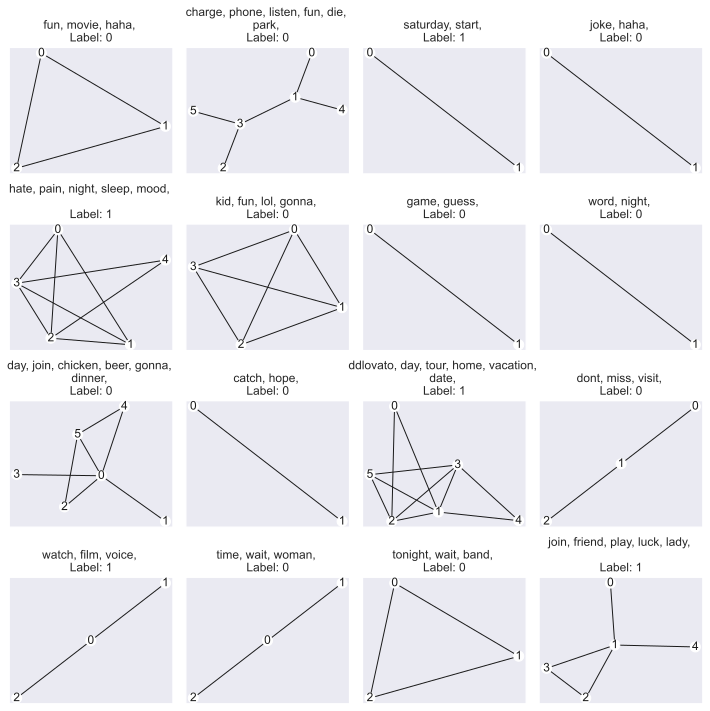

In [44]:
def format_ax_title(tweets, words):
    title = ''
    for i in range(len(words)):
        title += words[i] + ', '
        if i%4==0 and i > 0:
            title += '\n'
    title += '\n' + 'Label: ' + str(tweets.y[0].numpy()) 
    return title

fig, ax = plt.subplots(4, 4, figsize=(10,10))
sample_idx = np.random.choice(np.arange(len(twitter)), 16, replace=False)
feature_vector_to_word = lambda v : id2word[np.where(v)[0][0]]
for i, idx in enumerate(sample_idx):
    tweets = twitter[idx]
    words = [feature_vector_to_word(tweets.x[j]) for j in range(tweets.x.shape[0])]
    tweetG = to_networkx(tweets, to_undirected=True)
    title = format_ax_title(tweets, words)
    visualize_graph(ax[i//4,i%4], tweetG, labels=True, title=title)
plt.tight_layout()

## Load data

In [184]:
N_train = 50000
N_test = 1000
batch_size_train=128
batch_size_test=32

twitter_train_idx = np.random.choice(np.arange(len(twitter)), N_train, replace=False)
twitter_test_idx = np.random.choice(np.arange(len(twitter)), N_test, replace=False)

twitter_train_dataset = twitter[twitter_train_idx]
twitter_test_dataset = twitter[twitter_test_idx]

twitter_train_loader = DataLoader(twitter_train_dataset, batch_size=batch_size_train, shuffle=True)
twitter_test_loader = DataLoader(twitter_test_dataset, batch_size=batch_size_test, shuffle=False)

## Build models

In [185]:
class TwitterGNN(torch.nn.Module):
    def __init__(self, hidden_channels, embedding=None):
        super(TwitterGNN, self).__init__()
        if embedding:
            in_D = embeddings[embedding]['size']
            self.embedding_map = lambda x : torch.tensor(embeddings[embedding]['model'][torch.where(x)[1].numpy()])
        else:
            in_D = twitter.num_features
            self.embedding_map = None
        self.conv1 = GraphConv(in_D, hidden_channels) 
        self.conv2 = GraphConv(hidden_channels, hidden_channels//2)
        self.lin = Linear(hidden_channels//2, twitter.num_classes)

    def forward(self, x, edge_index, batch):
        # 0. apply optional word embeddings
        if self.embedding_map:      
            x = self.embedding_map(x)
        
        # 1. GCN embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer, to obtain a graph-level representation
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

# todo: compare these models against nlp-only baselines to see the impact of the GCN
twitter_gnn_model = TwitterGNN(64)
twitter_gnnword2vec_model = TwitterGNN(64, embedding='word2vec')
twitter_gnnglove_model = TwitterGNN(64, embedding='glove')
twitter_models = [twitter_gnn_model, twitter_gnnword2vec_model, twitter_gnnglove_model]
twitter_modelnames = ['GNN', 'Word2Vec GNN', 'Glove GNN']
for i in range(len(twitter_models)):
    print(twitter_modelnames[i], ':', twitter_models[i])

GNN : TwitterGNN(
  (conv1): GraphConv(1323, 64)
  (conv2): GraphConv(64, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)
Word2Vec GNN : TwitterGNN(
  (conv1): GraphConv(100, 64)
  (conv2): GraphConv(64, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)
Glove GNN : TwitterGNN(
  (conv1): GraphConv(25, 64)
  (conv2): GraphConv(64, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


## Train models

In [186]:
learning_rate = .001
optimizers = [torch.optim.Adam(m.parameters(), lr=learning_rate) for m in twitter_models]
criterion = torch.nn.CrossEntropyLoss()
assert len(twitter_models) == len(twitter_modelnames) == len(optimizers)

def train_step(model, loader, optimizer):
    model.train()
    losses = 0
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        losses += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return losses.detach().numpy()/len(loader) # average batch loss

def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # percent correct label

evaluate = lambda model : (test(model, twitter_train_loader), test(model, twitter_test_loader))

twitterlosses = {m : [] for m in twitter_modelnames}
twitteracc = {m : [] for m in twitter_modelnames}
for i, model in enumerate(twitter_models):
    print(twitter_modelnames[i])
    for epoch in range(100):
        loss = train_step(model, twitter_train_loader, optimizers[i])
        train_acc, test_acc = evaluate(model)
        twitterlosses[twitter_modelnames[i]].append(loss)
        twitteracc[twitter_modelnames[i]].append((train_acc, test_acc))
        if epoch%10==9: print(f'Epoch: {epoch}, loss: {np.around(loss, 2)}, acc: {np.around(test_acc, 2)}')

GNN
Epoch: 0, loss: 0.63, acc: 0.68
Epoch: 9, loss: 0.37, acc: 0.72
Epoch: 18, loss: 0.21, acc: 0.7
Epoch: 27, loss: 0.16, acc: 0.71
Epoch: 36, loss: 0.14, acc: 0.72
Epoch: 45, loss: 0.13, acc: 0.71
Epoch: 54, loss: 0.12, acc: 0.72
Epoch: 63, loss: 0.12, acc: 0.72
Epoch: 72, loss: 0.11, acc: 0.72
Epoch: 81, loss: 0.11, acc: 0.71
Epoch: 90, loss: 0.11, acc: 0.72
Epoch: 99, loss: 0.1, acc: 0.71
Word2Vec GNN
Epoch: 0, loss: 0.67, acc: 0.62
Epoch: 9, loss: 0.58, acc: 0.67
Epoch: 18, loss: 0.54, acc: 0.68
Epoch: 27, loss: 0.51, acc: 0.68
Epoch: 36, loss: 0.49, acc: 0.67
Epoch: 45, loss: 0.48, acc: 0.69
Epoch: 54, loss: 0.47, acc: 0.68
Epoch: 63, loss: 0.46, acc: 0.68
Epoch: 72, loss: 0.45, acc: 0.68
Epoch: 81, loss: 0.45, acc: 0.67
Epoch: 90, loss: 0.44, acc: 0.68
Epoch: 99, loss: 0.44, acc: 0.68
Glove GNN
Epoch: 0, loss: 0.69, acc: 0.55
Epoch: 9, loss: 0.63, acc: 0.64
Epoch: 18, loss: 0.62, acc: 0.65
Epoch: 27, loss: 0.61, acc: 0.66
Epoch: 36, loss: 0.6, acc: 0.68
Epoch: 45, loss: 0.6, acc

## Plot evaluation

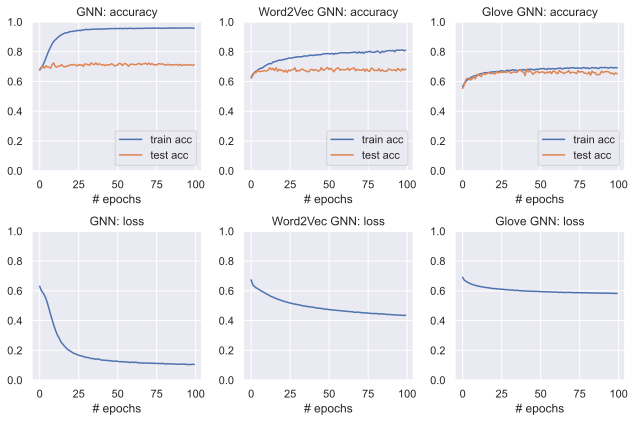

In [243]:
plot_results(twitterlosses, twitteracc, twitter_modelnames)

# Airports

In [17]:
airports = torch_geometric.datasets.Airports(root='data/', name='USA')

In [236]:
print(f'Dataset: {airports}:')
print('======================')
print(f'Number of graphs: {len(airports)}')
print(f'Number of features: {airports.num_features}')
print(f'Number of classes: {airports.num_classes}')
airport_data = airports[0]
airport_graph = to_networkx(airport_data)
airport_df = pd.DataFrame(airport_data.y, columns=['label'])

airport_df['num_neighbors'] = [len(list(airport_graph.neighbors(i))) for i in range(airport_data.num_features)]

print(airport_data)

Dataset: UsaAirports():
Number of graphs: 1
Number of features: 1190
Number of classes: 4
Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])


## Withouth knowing which airport is which, we will plot them as points in 3d, and draw lines between nodes if their airports are connected in the UsaAirports dataset

## Without knowing what the labels mean, it seems the labels have something to do with the connectedness of the nodes. The labels are equally balanced (1190=297+297+297+299)

## Here we are viewing approximately 40% of the nodes of the graph, since it is too dense to view the whole thing

In [246]:
plot_subgraph_3d(airport_graph, airport_data, N=500)

### A correlation between node degree (# of neighbors) and the label

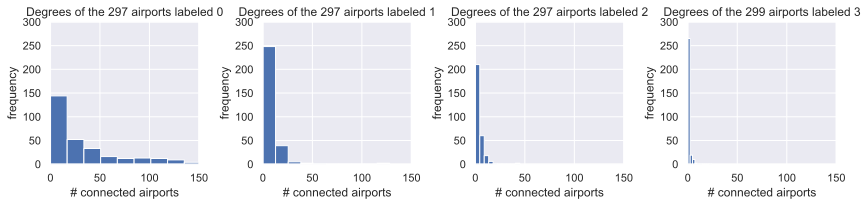

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

for i in range(4):
    subdf= airports_df[airports_df['label']==i]
    ax[i].hist(subdf.num_neighbors)    
    ax[i].set_xlabel('# connected airports')
    ax[i].set_ylabel('frequency')
    ax[i].set_xlim((0,150))
    ax[i].set_ylim((0,300))
    ax[i].set_title(f'Degrees of the {len(subdf)} airports labeled {i}')
plt.tight_layout()

## As a baseline against a GNN, here is a logistic regression model using the # of neighbors as its only feature

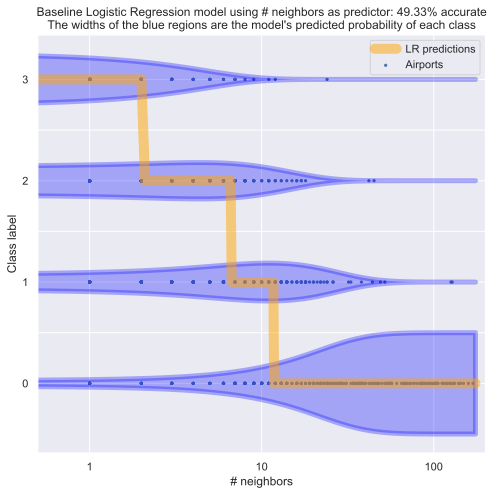

In [194]:
fig, ax = plt.subplots(figsize=(7,7))

# plot airports by their # of neighbors and class label
ax.scatter(airports_df.num_neighbors, airports_df.label, sizes=5*np.ones(len(airports_df)), label='Airports')

# fit logistic regression model just using the # neighbors to predict the label
train_idx = np.random.choice(np.arange(len(airports_df)), 700, replace=False)
test_idx = np.random.choice(np.arange(len(airports_df)), 300, replace=False)
dftrain, dftest = airports_df.loc[train_idx], airports_df.loc[test_idx]
xtrain, ytrain, xtest, ytest = dftrain.num_neighbors.values, dftrain.label.values, dftest.num_neighbors.values, dftest.label.values
lr = LogisticRegression()
lr.fit(xtrain.reshape(-1,1), ytrain)
ypred = lr.predict(xtest.reshape(-1,1))
probs = lr.predict_proba(xplot.reshape(-1,1))
accuracy = sklearn.metrics.accuracy_score(ytest, ypred)

# plot logistic regression model predictions
xplot = np.arange(0,175,.1)
plotpreds = lr.predict(xplot.reshape(-1,1))
ax.plot(xplot, plotpreds, linewidth=10, color='orange', alpha=0.5, label = 'LR predictions')

# fill a region of space whose width changes proportional to the predicted probabiltiy of the LR model for each class
for i in range(4):
    ax.fill_between(xplot, i - 0.5*probs[:,i], i + 0.5*probs[:,i], linewidth=5, color='blue', alpha=0.3)

# format
title = f'Baseline Logistic Regression model using # neighbors as predictor: {round(accuracy*100,2)}% accurate'
title += '\nThe widths of the blue regions are the model\'s predicted probability of each class'
ax.set_title(title)
ax.set_xscale('log')
ax.set_xlim([.5,200])
ax.set_xticks([1, 10, 100])
ax.set_xticklabels(['1', '10', '100'])
ax.set_yticks(np.arange(0,3.5,0.5))
ax.set_yticklabels(['0','','1','','2','','3'])
ax.set_xlabel('# neighbors')
ax.set_ylabel('Class label')
ax.legend(loc='best')

plt.tight_layout()

## Load data

In [216]:
N_train = 70
N_test = 30

airport_train_idx = np.random.choice(np.arange(airports.num_features), N_train, replace=False)
airport_test_idx = np.random.choice(np.arange(airports.num_features), N_test, replace=False)

airport_train_mask = np.array([idx in airport_train_idx for idx in range(airports.num_features)])
airport_test_mask = np.array([idx in airport_test_idx for idx in range(airports.num_features)])

## Build models

In [225]:
class AirportGNN(torch.nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.conv1 = layer(airports.num_features, 100)
        self.conv2 = layer(100, 10)
        self.conv3 = layer(10, 2)
        self.classifier = Linear(2, airports.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

airport_gcnconv_model = AirportGNN(GCNConv)
airport_graphconv_model = AirportGNN(GraphConv)
airport_models = [airport_gcnconv_model, airport_graphconv_model]
airport_modelnames = ['GCNConv', 'GraphConv']
for i in range(len(airport_models)):
    print(airport_modelnames[i], ':', airport_models[i])

GCNConv : AirportGNN(
  (conv1): GCNConv(1190, 100)
  (conv2): GCNConv(100, 10)
  (conv3): GCNConv(10, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)
GraphConv : AirportGNN(
  (conv1): GraphConv(1190, 100)
  (conv2): GraphConv(100, 10)
  (conv3): GraphConv(10, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


## Train models

In [231]:
learning_rate = .003
optimizers = [torch.optim.Adam(m.parameters(), lr=learning_rate) for m in airport_models]
criterion = torch.nn.CrossEntropyLoss()
assert len(airport_models) == len(airport_modelnames) == len(optimizers)

def train_step(model, optimizer):
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out, h = model(airports_data.x, airports_data.edge_index)  # Forward pass on whole graph
    loss = criterion(out[airport_train_mask], airports_data.y[airport_train_mask])  # Loss on training nodes
    loss.backward()  # Calculate gradients
    optimizer.step()  # Update parameters based on gradients
    return loss.detach().numpy(), out, h

def test(out, mask):
    pred = out[mask].argmax(dim=1)  # Use the class with highest probability
    acc = int((pred == airports_data.y[mask]).sum()) / mask.sum() # Percent correct
    return acc

evaluate = lambda out : (test(out, airport_train_mask), test(out, airport_test_mask))

airportlosses = {m : [] for m in airport_modelnames}
airportacc = {m : [] for m in airport_modelnames}
airportemb = {m : [] for m in airport_modelnames}

# sample_idx = np.random.choice(np.arange(airports.num_features), 100)
n_epochs=30

for i, model in enumerate(airport_models):
    name = airport_modelnames[i]
    print(name)
    for epoch in range(n_epochs):
        loss, out, h = train_step(model, optimizers[i])
        train_acc, test_acc = evaluate(out)
        airportlosses[name].append(loss)
        airportacc[name].append((train_acc, test_acc))
        airportemb[name].append(h)
        if epoch%10==9: 
            print(f'Epoch: {epoch}, loss: {np.around(loss, 2)}, acc: {np.around(test_acc, 2)}')

GCNConv
Epoch: 9, loss: 0.8700000047683716, acc: 0.43
Epoch: 19, loss: 0.8299999833106995, acc: 0.5
Epoch: 29, loss: 0.7900000214576721, acc: 0.43
GraphConv
Epoch: 9, loss: 1.0, acc: 0.43
Epoch: 19, loss: 0.9200000166893005, acc: 0.43
Epoch: 29, loss: 0.8600000143051147, acc: 0.43


## Plot evaluation

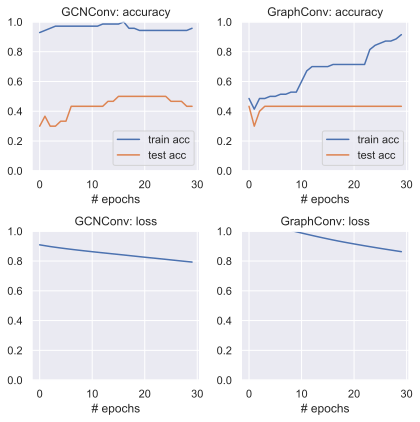

In [248]:
plot_results(airportlosses, airportacc, airport_modelnames)

## Visualize the change in the last layer embeddings during training

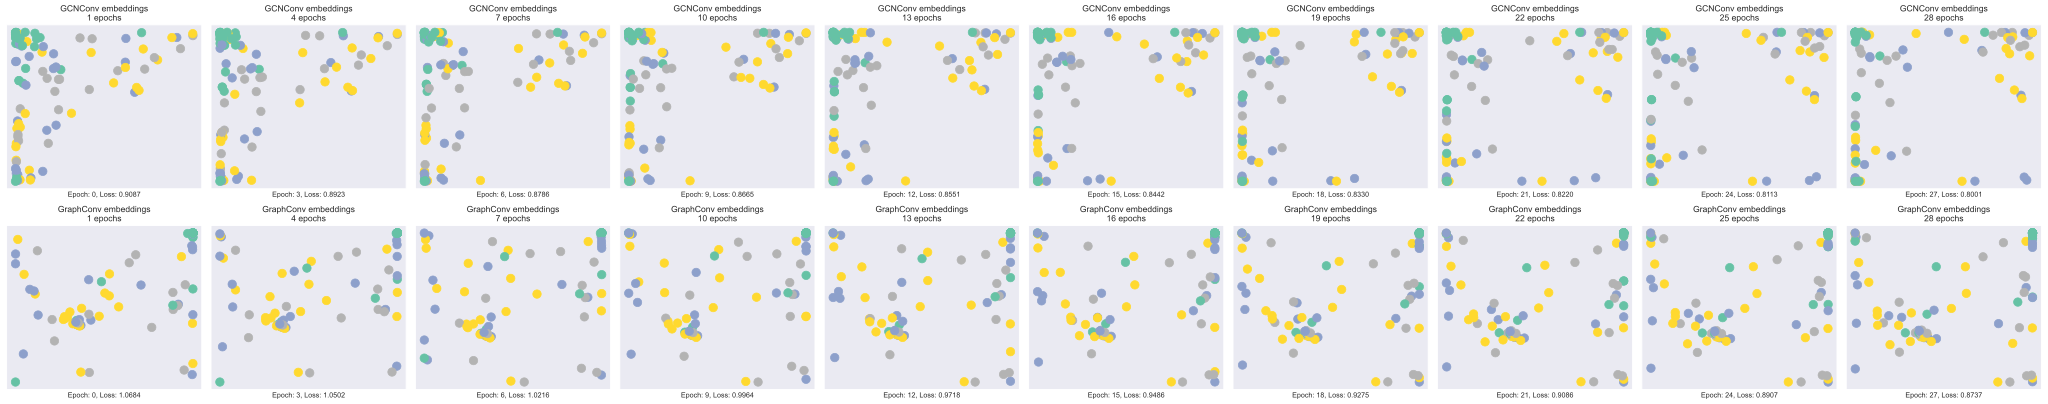

In [249]:
sample_idx = np.random.choice(np.arange(airports.num_features), 100)
n_plots=10
n_models = 2
fig, ax = plt.subplots(n_models, n_plots, figsize=(4*n_plots,4*n_models))

for i, model in enumerate(airport_models):
    name = airport_modelnames[i]
    for n in range(n_plots):
        epoch = n*n_epochs//n_plots
        h = airportemb[name][epoch]
        loss = airportlosses[name][epoch]
        visualize_embedding(ax[i,n], h[sample_idx], color=airports_data.y[sample_idx], epoch=epoch, loss=loss, title=f'{name} embeddings\n{epoch+1} epochs')
plt.tight_layout()

## Visualize the the last layer embedding space after training

In [316]:
visualize_model_embedding_spaces(airport_models, airport_modelnames)
    

<ipython-input-297-e4104e03d506>:13: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.

